# The Zangellini Similarity

In [1]:
# Imports
from tqdm import tqdm_notebook
import numpy as np
from matplotlib import pyplot as plt
from quantum_systems import OneDimensionalHarmonicOscillator
from quantum_systems.time_evolution_operators import LaserField
from coupled_cluster.ccsd import TDCCSD
from coupled_cluster.ccd import TDCCD
from coupled_cluster.integrators import GaussIntegrator
from tdhf import HartreeFock
from coupled_cluster.mix import DIIS

In [2]:
# Major Lazer
class LaserPulse:
    def __init__(self, laser_frequency=2, laser_strength=1):
        self.laser_frequency = laser_frequency
        self.laser_strength = laser_strength

    def __call__(self, t):
        return self.laser_strength * np.sin(self.laser_frequency * t)

In [3]:
# The Zanghellini system
n = 2
l = 6
length = 10
num_grid_points = 400
omega = 0.25
laser_frequency = 8 * omega
laser_strength = 1

zanghellini = OneDimensionalHarmonicOscillator(
    n, l, length, num_grid_points, omega=omega
)
zanghellini.setup_system()
major_laser = LaserField(
    LaserPulse(
        laser_frequency=laser_frequency, laser_strength=laser_strength
    )
)

zanghellini_2 = OneDimensionalHarmonicOscillator(
    n, l, length, num_grid_points, omega=omega
)

zanghellini_2.setup_system()
lazer_blazer = LaserField(
    LaserPulse(
        laser_frequency=laser_frequency, laser_strength=laser_strength
    )
)

zanghellini.set_time_evolution_operator(major_laser)

zanghellini_2.set_time_evolution_operator(lazer_blazer)

In [4]:
# zanghellini.change_to_hf_basis(tolerance=1e-6)
# zanghellini_2.change_to_hf_basis(tolerance=1e-6)

In [5]:
tdccsd_zanghellini = TDCCSD(zanghellini, 
                            np=np, 
                            verbose=True, 
                            mixer=DIIS, 
                            integrator=GaussIntegrator(np=np, eps=1e-8))
tdccsd_zanghellini.compute_ground_state(t_kwargs=dict(num_vecs=5), l_kwargs=dict(num_vecs=5))
print(f"HF->CCSD ground state energy: {tdccsd_zanghellini.compute_ground_state_energy().real:8.7}")

Iteration: 0	Residuals (t): [0.22078529827281276, 0.20917782593194595]
Iteration: 1	Residuals (t): [0.30028116545848893, 0.532688892876194]
Iteration: 2	Residuals (t): [0.022216846448074798, 0.22033727972001976]
Iteration: 3	Residuals (t): [0.005069238699527775, 0.02805567027096152]
Iteration: 4	Residuals (t): [0.0007082182840103967, 0.024495938876415626]
Iteration: 5	Residuals (t): [0.0003485235102961406, 0.011952436456220067]
Iteration: 6	Residuals (t): [0.00037744534845019406, 0.0006542097134716551]
Iteration: 7	Residuals (t): [0.00019626825803633862, 0.00023357655485613932]
Iteration: 8	Residuals (t): [7.832397047986702e-05, 0.000148705447443911]
Iteration: 9	Residuals (t): [2.0712103730497124e-05, 2.159526386133091e-06]
Iteration: 0	Residuals (l): [0.41997685575125715, 1.25130125741837]
Iteration: 1	Residuals (l): [0.21671678211186474, 1.6794617603304258]
Iteration: 2	Residuals (l): [0.09967588987885938, 0.0926063167758203]
Iteration: 3	Residuals (l): [0.0278735565882945, 0.099684

In [6]:
tdccd_zanghellini = TDCCD(zanghellini_2, 
                            np=np, 
                            verbose=True, 
                            mixer=DIIS, 
                            integrator=GaussIntegrator(np=np, eps=1e-8))
tdccd_zanghellini.compute_ground_state(t_kwargs=dict(num_vecs=5), l_kwargs=dict(num_vecs=5))
print(f"HF->CCD ground state energy: {tdccd_zanghellini.compute_ground_state_energy().real:8.7}")

Iteration: 0	Residuals (t): [0.5809837655997323]
Iteration: 1	Residuals (t): [0.44448195713599437]
Iteration: 2	Residuals (t): [0.06002100358021992]
Iteration: 3	Residuals (t): [0.015616083668304512]
Iteration: 4	Residuals (t): [0.0011833811276255573]
Iteration: 5	Residuals (t): [6.573444195830687e-05]
Iteration: 0	Residuals (l): [0.9154844304499935]
Iteration: 1	Residuals (l): [0.802020319904819]
Iteration: 2	Residuals (l): [0.03919151470792436]
Iteration: 3	Residuals (l): [4.500329672081747e-14]
HF->CCD ground state energy: 1.106318


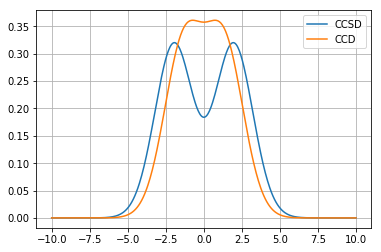

In [7]:
rho = tdccsd_zanghellini.compute_ground_state_particle_density()
rho_2 = tdccd_zanghellini.compute_ground_state_particle_density()
plt.plot(zanghellini.grid, rho.real, label="CCSD")
plt.plot(zanghellini_2.grid, rho_2.real, label="CCD")
plt.legend()
plt.grid()
plt.show()

In [8]:
tdccsd_zanghellini.set_initial_conditions()
tdccd_zanghellini.set_initial_conditions()

In [9]:
num_time_steps = 501
time_points = np.linspace(0, 5, num_time_steps)
psi_overlap_tdccsd = np.zeros(num_time_steps)
td_energies_tdccsd = np.zeros(num_time_steps)
psi_overlap_tdccd = np.zeros(num_time_steps)
td_energies_tdccd = np.zeros(num_time_steps)

psi_overlap_tdccsd[0] = tdccsd_zanghellini.compute_time_dependent_overlap().real
td_energies_tdccsd[0] = tdccsd_zanghellini.compute_energy().real
psi_overlap_tdccd[0] = tdccd_zanghellini.compute_time_dependent_overlap().real
td_energies_tdccd[0] = tdccd_zanghellini.compute_energy().real

In [10]:
for i, amp in tqdm_notebook(enumerate(tdccsd_zanghellini.solve(time_points)), total=num_time_steps-1):
    psi_overlap_tdccsd[i + 1] = tdccsd_zanghellini.compute_time_dependent_overlap().real
    td_energies_tdccsd[i + 1] = tdccsd_zanghellini.compute_energy().real

for i, amp in tqdm_notebook(enumerate(tdccd_zanghellini.solve(time_points)), total=num_time_steps-1):
    psi_overlap_tdccd[i + 1] = tdccd_zanghellini.compute_time_dependent_overlap().real
    td_energies_tdccd[i + 1] = tdccd_zanghellini.compute_energy().real

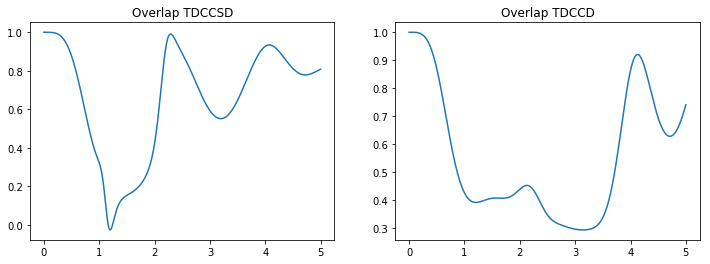

In [11]:
fix, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(time_points, psi_overlap_tdccsd)
ax[0].set_title("Overlap TDCCSD")
ax[1].plot(time_points, psi_overlap_tdccd)
ax[1].set_title("Overlap TDCCD")
plt.show()

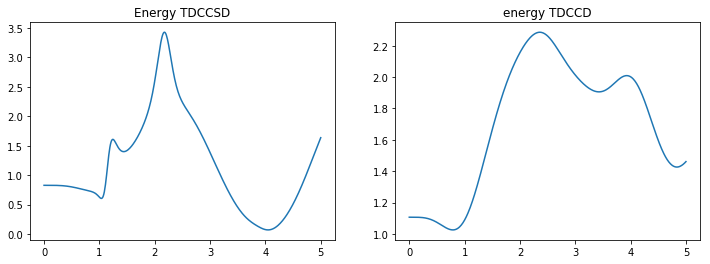

In [12]:
fix, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(time_points, td_energies_tdccsd)
ax[0].set_title("Energy TDCCSD")
ax[1].plot(time_points, td_energies_tdccd)
ax[1].set_title("energy TDCCD")
plt.show()